At first, I let the xgboost impute the missing values by itself. The `mean_absolute_error` of the validation dataset we're OK. But when I submit the predictions of the testdata, `mean_absolute_error` was almost double, meaning my model is `Overfitting`. After testing the model with several combinations of hyperparameters, I find no improvemnet, the model was still tending to Overfit. My intuition is that letting xgboost impute the values is causing the `Overfitting`.

In [2]:
import numpy as np 
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

In [4]:
df = pd.read_csv('train.csv')

In [5]:
pd.read_csv('test.csv')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [9]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = list(set(X.columns) - set(categorical_cols))

In [10]:
def eval_model(my_model, train_X=X_train, train_y=y_train, val_X=X_val, val_y=y_val, verbose=False):
    preds = my_model.predict(val_X)
    if (verbose):
        print(f"mean absolute error = {mean_absolute_error(val_y, preds)}")
    return mean_absolute_error(val_y, preds)

In [11]:
def save_prediction(my_model):
    X_test = pd.read_csv('test.csv')
    preds = my_model.predict(X_test)
    my_submission = pd.DataFrame(
        {
            'Id' : X_test['Id'],
            'SalePrice' : preds
        }
    )
    my_submission.to_csv("Final Submission.csv", index=False)

In [12]:
def create_and_fit_pipline(model, train_X = X_train, train_y = y_train, val_X = X_val, val_y = y_val):
    
    numerical_transformer = SimpleImputer(strategy='mean')

    categorical_transformer = Pipeline(
        steps = [
            ('cat_imp',SimpleImputer(strategy='most_frequent')),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))
        ]
    )

    preprocessor = ColumnTransformer(
        transformers = [
            ('numerical_transformer', numerical_transformer, numerical_cols),
            ('categorical_transformer', categorical_transformer, categorical_cols)
        ]
    )

    my_pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('my_model', model)
        ]
    )
    my_pipeline.fit(train_X, 
                    train_y)
    return my_pipeline

In [13]:
model1 = XGBRegressor(random_state=43)
my_pipeline1 = create_and_fit_pipline(model1)
eval_model(my_pipeline1)

17585.19104505565

In [14]:
model2 = XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 400,
    learning_rate = 0.1,
    eval_metric = 'mae',
    random_state=42,
    max_depth=5
)
my_pipeline2 = create_and_fit_pipline(model2)
eval_model(my_pipeline2)

15786.143220248288

In [15]:
model3 = XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 1000,
    learning_rate = 0.1,
    eval_metric = 'mae',
    random_state=42,
    max_depth=5
)
my_pipeline3 = create_and_fit_pipline(model3)
eval_model(my_pipeline3)

15807.82084760274

In [16]:
grid = {
    'n_estimators' : [100, 200, 400, 1000],
    'learning_rate' : [0.1, 0.05, 0.01],
    'max_depth' : [3, 4, 5, 10],
    'gamma' : [0, 0.1, 0.25, 1],# encourages pruing
    'reg_lambda' : [0, 0.1, 1, 10] #  penalty added to prevent overfitting
}

gs_model = GridSearchCV(
    estimator = XGBRegressor(objective='reg:squarederror',
                             random_state=42,
                             subsample=0.9,
                             colsample_bytree=0.5),
    param_grid=grid,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=10,
    cv=5,
)


In [17]:
# my_gs_pipeline = create_and_fit_pipline(gs_model)
# eval_model(my_gs_pipeline)

In [18]:
# gs_model.best_params_ 

- The best params found are

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 400,
 'reg_lambda': 0}

- mae = 15623.166510595034

- The best params found are

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 1000,
 'reg_lambda': 1}

- mae = 15497.308192422945

In [19]:
# save_prediction(my_gs_pipeline)
# eval_model(my_gs_pipeline)

In [20]:
def plot_change(hyperparam, start, stop, step, verbose = False):
    
    arr = []
    values = np.arange(start, stop, step)

    for val in values:
        params = {
                'objective' : 'reg:squarederror',
                'eval_metric' : 'mae',
                'n_estimators' : 1000,
                'learning_rate' : 0.05,
                'max_depth' : 3,
                'reg_lambda' : 1,
                'random_state' : 42,
                'subsample' : 0.9,
                'colsample_bytree' : 0.2,
                'n_jobs' : 10
        }
        params[hyperparam] = val
        my_model = XGBRegressor(**params)
        my_pipeline = create_and_fit_pipline(my_model)
        ans = eval_model(my_pipeline, verbose=verbose)
        arr.append(ans)
        
    plt.figure(figsize=(5,5))
    plt.plot(values, arr)
    plt.xlabel(hyperparam)
    plt.ylabel('mean_absolute_error')
    return values[arr.index(min(arr))]

0.2

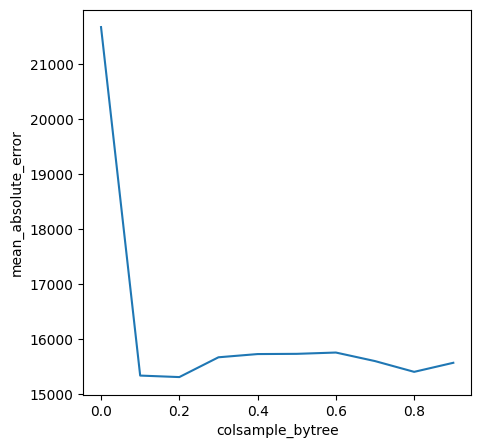

In [21]:
plot_change('colsample_bytree', 0, 1, 0.1)

In [22]:
params = {
            'objective' : 'reg:squarederror',
            'eval_metric' : 'mae',
            'n_estimators' : 1000,
            'learning_rate' : 0.05,
            'max_depth' : 3,
            'reg_lambda' : 1,
            'random_state' : 42,
            'subsample' : 0.9,
            'colsample_bytree' : 0.2,
            'n_jobs' : 10
    }

In [23]:
model4 = XGBRegressor(**params)
pipeline4 = create_and_fit_pipline(model4)
eval_model(pipeline4)

15310.84773651541

In [24]:
save_prediction(pipeline4)

mean absolute error = 19468.639019691782
mean absolute error = 17263.681493471748
mean absolute error = 15923.891200235445
mean absolute error = 15602.096372003425
mean absolute error = 15588.795028895547
mean absolute error = 15188.447131849314
mean absolute error = 15372.753143728596
mean absolute error = 15145.08851937072
mean absolute error = 15593.96004120291
mean absolute error = 15033.640939372859
mean absolute error = 15281.463084599744
mean absolute error = 14863.865809610445
mean absolute error = 15326.78169145976
mean absolute error = 15136.287938784246
mean absolute error = 15634.839442422945
mean absolute error = 15448.268340646404
mean absolute error = 15379.663861836472
mean absolute error = 15786.346780019263


13

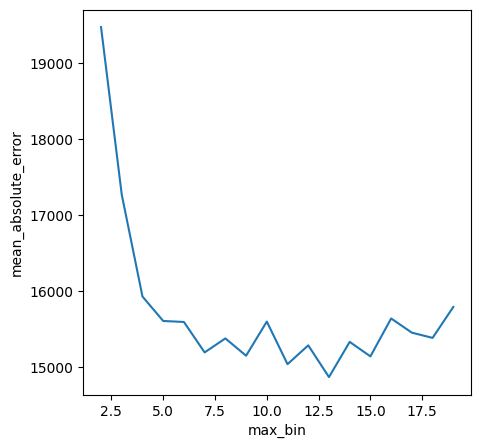

In [25]:
plot_change('max_bin', 2, 20, 1, True)

In [26]:
params['max_bin'] = 13
model5 = XGBRegressor(**params)
my_pipeline5 = create_and_fit_pipline(model5)
eval_model(my_pipeline5)

14863.865809610445

In [27]:
save_prediction(my_pipeline5)

In [28]:
model4.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.2, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=10,
             num_parallel_tree=None, random_state=42, ...)>

mean absolute error = 17982.47387360873
mean absolute error = 17051.881421232876
mean absolute error = 15940.998274293665
mean absolute error = 15689.820673694348
mean absolute error = 15632.272260273972
mean absolute error = 15124.601361836472
mean absolute error = 15310.84773651541
mean absolute error = 15310.84773651541


7

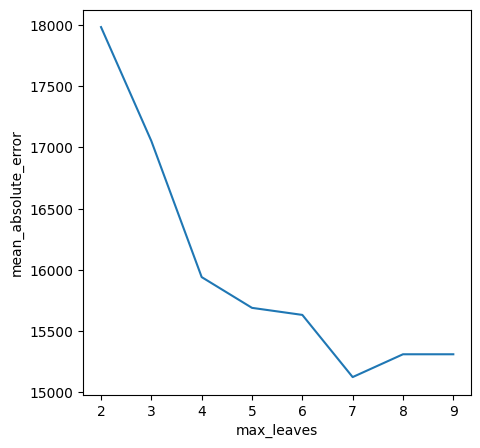

In [29]:
plot_change('max_leaves', 2, 10, 1, True)

mean absolute error = 15310.84773651541
mean absolute error = 15310.84773651541
mean absolute error = 15310.84773651541
mean absolute error = 15310.84773651541
mean absolute error = 15598.073630136987
mean absolute error = 15598.073630136987
mean absolute error = 15598.073630136987
mean absolute error = 15503.241665774829
mean absolute error = 15503.241665774829
mean absolute error = 15503.241665774829
mean absolute error = 15503.241665774829
mean absolute error = 15706.660316780823
mean absolute error = 15706.660316780823
mean absolute error = 15706.660316780823
mean absolute error = 15894.004762414384
mean absolute error = 15894.004762414384
mean absolute error = 15894.004762414384


0.0

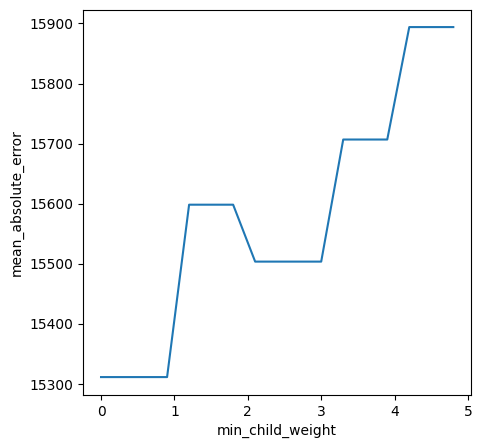

In [30]:
plot_change('min_child_weight', 0, 5, 0.3, True)

Looks like no major improvement is possible further.